In [18]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math
import matplotlib.patches as patches
import time

Two thresholding operators (with Otsu): inside `detect_roi` and inside `compute_barcode_structure`. We want to explore the possibility to use again the same theshold.

In [19]:
def detect_roi(image, visualize_bounding_box=False):
    """Detect the ROI surrounding the barcode in the given image.

    It returns the bounding box coordinates. 
    This works both if the barcode is non-rotated (i.e. the bars are vertical) and if the barcode is rotated (i.e. the bars 
    are horizontal). 

    Parameters
    ----------
    image : np.array
        Input image.
    visualize_bounding_box : bool, optional
        Whether to visualize or not the input image with the detected bounding box, by default False

    Returns
    -------
    bb_points_sorted : np.array
        Array 4x2, containing the coordinates of the four bounding box points. 
        The points are ordered in the following way: up-left, up-right, bottom-left, bottom-right.

    """

    # Convert the image to grey scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute both the horizontal and vertical derivative, using the Sobel filter
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    # Subtract the y-gradient from the x-gradient: we get the final gradient image
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    # Blur the gradient image    
    blurred = cv2.blur(gradient, (9, 9))

    # Threshold the gradient image
    threshold ,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print('Threshold1:',threshold)
    
    # Closing: fill the bounding box
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # Opening: remove small things outside
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    # Dilate: slight enlarge the box
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    dilated = cv2.dilate(opened, kernel, iterations=3)
    
    # Find the bounding box (OpenCV API)
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # Compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    # This is our bounding box: 4 points, each of them 2 coordinates
    box = np.int0(box)  

    if visualize_bounding_box:
        # Draw a bounding box around the detected barcode and display the image
        image_bb = image.copy()
        cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
        plt.figure()
        plt.imshow(image_bb, 'gray')
        plt.title('Original image, with the bounding box')
    
    # Sorting the points of the bounding box, such that they follow the ordering: up-left, up-right, bottom-left, bottom-right.
    bb_points_sorted = box.astype('float32')
    min_width = bb_points_sorted[:,0].min()
    min_height = bb_points_sorted[:,1].min()
    max_width = bb_points_sorted[:,0].max()
    max_height = bb_points_sorted[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    bb_points_sorted = np.array(sorted([tuple(v) for v in bb_points_sorted], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    
    # Compute the width and height of the bounding box.
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    bb_height = int(max([dist(bb_points_sorted[0],bb_points_sorted[2]),
                             dist(bb_points_sorted[1],bb_points_sorted[3])]))
    bb_width = int(max([dist(bb_points_sorted[0],bb_points_sorted[1]),
                             dist(bb_points_sorted[2],bb_points_sorted[3])]))


    return bb_points_sorted, bb_width, bb_height

In [20]:
def compute_barcode_structure(roi_image, bb_width, bb_height, algorithm=1, verbose=False, visualize_refined_bb=False,
                              visualize_barcode_structure=False):
    """Compute the complete barcode structure.

    Namely, it computes:
    - the starting pixel of each bar;
    - the width of each bar;
    - the half height up of each bar;
    - the half height down of each bar.

    Parameters
    ----------
    roi_image : np.array
        The original image cropped around the ROI (i.e. the barcode)
    bb_width : int
        Width of the bounding box
    bb_height : int
        Height of the bounding box
    algorithm : int, optional
        Algorithm to use for computing the barcode structure, by default 1.
        Choices among 1,2,3,4.
    verbose : bool, optional
        Whether to print the solving time or not, by default False
    visualize_refined_bb : bool, optional
        Whether to visualize the refined ROI image or not, by default False
    visualize_barcode_structure : bool, optional
        Whether to visualize the barcode structure or not, by default False

    Returns
    -------
    bars_start : list of int
        List containing the starting pixel of each bar
    bars_width : list of int
        List containing the width of each bar
    bars_halfHeightUp : list of int
        List containing the half heigth up of each bar
    bars_halfHeightDown : list of int
        List containing the half height down of each bar

    Raises
    ------
    ValueError
        If a wrong algorithm index is given

    """
    threshold ,ROI_thresh = cv2.threshold(roi_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print('Threshold2:', threshold)
    
    start_time = time.time()

    if algorithm==1:
        algorithm_function = _algorithm1
    elif algorithm==2:
        algorithm_function = _algorithm2
    elif algorithm==3:
        algorithm_function = _algorithm3
    elif algorithm==4:
        algorithm_function = _algorithm4
    else:
        raise ValueError(f'Invalid algorithm {algorithm}')

    bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown = algorithm_function(ROI_thresh, bb_width, bb_height)
       
    first_bar_x = min(bars_start)
    last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1
    X = min(bars_width)
    min_half_height_up = min(bars_halfHeightUp)
    min_half_height_down = min(bars_halfHeightDown)
    
    half_height = math.ceil(bb_height/2)
    
    end_time = time.time()

    if verbose:
        print('Time:', end_time-start_time)    
  
    if visualize_refined_bb:      
        plt.figure(figsize=(3, 3))
        plt.imshow(roi_image, 'gray')
        plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
        plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min down height')
        plt.axvline(first_bar_x, c='red', label='first_bar_x')
        plt.axvline(last_bar_x, c='orange', label='last_bar_x')
        plt.title('Refined ROI, with the computed quantities')
        plt.legend()

    if visualize_barcode_structure:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(roi_image, 'gray')
        n_bars = len(bars_start)
        for b in range(n_bars):
            # Create a Rectangle patch
            rect = patches.Rectangle((bars_start[b]-0.5, half_height-bars_halfHeightUp[b]-1-0.5), bars_width[b], 
                                     bars_halfHeightUp[b]+bars_halfHeightDown[b]+1, linewidth=1, edgecolor='r', facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
        plt.show()
        ax.set_title('Exaustive barcode structure')
    
    
    return bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown



###### ALGORITHM 1
def _algorithm1(ROI_thresh, bb_width, bb_height):
    half_height = math.ceil(bb_height/2)
    half_height_index = half_height-1

    # INIZIALIZATION
    bars_start = []
    bars_width = []
    bars_halfHeightUp = []
    bars_halfHeightDown = []

    i = 0  # Index for iterating over the pixels

    # CYCLE
    # We scan each pixel along the horizontal line in the exact middle of the ROI image
    while i<bb_width:

        # White pixel: we go to the next pixel
        if ROI_thresh[half_height_index, i]==255:
            i += 1
            continue

        # Black pixel
        # 'i' is the first pixel in this current barcode bar

        # Width of this current bar
        X_curr = 1    
        # Index representing the last pixel in this current bar. Actually, `i_end` is the pixel after the last pixel (i.e. 
        # first white pixel)
        i_end = i+1

        # We go right, till finding a white pixel.
        # In this way, we compute the width of this current bar.
        while ROI_thresh[half_height_index, i_end]==0:
            X_curr += 1
            i_end += 1

        # Now we search upward and downward along the vertical line 'i_med'.
        i_med = int((i+i_end)/2)
        # Index for goind upward.
        j_up = half_height_index-1
        # Index for goind downward.
        j_down = half_height_index+1
        # Half upward height of this current bar
        half_height_up_curr = 0
        # Half downard height of this current bar
        half_height_down_curr = 0

        # Cycle, in which we go upward and downard at the same time, for computing `half_height_up_curr` and 
        # `half_height_down_curr`

        # Flag saying whether the max up height has been reached or not: the three consecutive pixels i_med-1, i_med, I-med+1
        # must be all white (on the level j_up)
        up_reached = j_up<0 or (ROI_thresh[j_up, i_med]==255 and  ROI_thresh[j_up, i_med-1]==255 and ROI_thresh[j_up, i_med+1]==255)
        # Flag saying whether the max down height has been reached or not: the three consecutive pixels i_med-1, i_med, I-med+1
        # must be all white (on the level j_down)
        down_reached = j_down<0 or (ROI_thresh[j_down, i_med]==255 and  ROI_thresh[j_down, i_med-1]==255 and ROI_thresh[j_down, i_med+1]==255)
        
        while not up_reached or not down_reached:
            if not up_reached:
                j_up -= 1
                half_height_up_curr += 1
            if not down_reached:
                j_down += 1
                half_height_down_curr += 1
            up_reached = j_up<0 or (ROI_thresh[j_up, i_med]==255 and  ROI_thresh[j_up, i_med-1]==255 and ROI_thresh[j_up, i_med+1]==255)
            down_reached = j_down>=bb_height or (ROI_thresh[j_down, i_med]==255 and  ROI_thresh[j_down, i_med-1]==255 and ROI_thresh[j_down, i_med+1]==255)

        # Update the lists, inserting the values for this current bar
        bars_start.append(i)
        bars_width.append(X_curr)
        bars_halfHeightUp.append(half_height_up_curr)
        bars_halfHeightDown.append(half_height_down_curr)

        # We update `i`: we pass to the white pixel right after the current bar
        i = i_end
    
    return bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown


###### ALGORITHM 2
def _algorithm2(ROI_thresh, bb_width, bb_height):
    half_height = math.ceil(bb_height/2)
    half_height_index = half_height-1

    # INIZIALIZATION
    i = 0  # Index for iterating over the pixels

    bars_start = []
    bars_width = []
    bars_halfHeightUp = []
    bars_halfHeightDown = []

    # CYCLE
    # We scan each pixel along the horizontal line in the exact middle of the ROI image
    while i<bb_width:

        # White pixel: we go to the next pixel
        if ROI_thresh[half_height_index, i]==255:
            i += 1
            continue

        # Black pixel
        # 'i' is the first pixel in this current barcode bar

        # Width of this current bar
        X_curr = 1    
        # Index representing the last pixel in this current bar. Actually, `i_end` is the pixel after the last pixel (i.e. 
        # first white pixel)
        i_end = i+1

        # We go right, till finding a white pixel.
        # In this way, we compute the width of this current bar.
        while ROI_thresh[half_height_index, i_end]==0:
            X_curr += 1
            i_end += 1

        # Now we search upward and downward
        # Index for goind upward.
        j_up = half_height_index-1
        # Index for goind downward.
        j_down = half_height_index+1
        # Half upward height of this current bar
        half_height_up_curr = 0
        # Half downard height of this current bar
        half_height_down_curr = 0

        # Flag saying whether the max up height has been reached or not
        up_reached = j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.33         
        # Flag saying whether the max down height has been reached or not
        down_reached = j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.33

        # Cycle, in which we go upward and downard at the same time, for computing `half_height_up_curr` and 
        # `half_height_down_curr`
        while not up_reached or not down_reached:

            if not up_reached:
                half_height_up_curr += 1
            if not down_reached:
                half_height_down_curr += 1

            # We separate the increasing of `X_curr` left, right, up, down: 4 possibilities

            # Left increasing of `X_curr` on the vertical level `j_up`. "Left increasing" means before the index `i`.
            X_inc_left_up = 0
            # Right increasing of `X_curr` on the vertical level `j_up`. "Right increasing" means after the index `i_end`.
            X_inc_right_up = 0
            # Left increasing of `X_curr` on the vertical level `j_down`. "Left increasing" means before the index `i`.
            X_inc_left_down = 0
            # Right increasing of `X_curr` on the vertical level `j_down`. "Right increasing" means after the index `i_end`.
            X_inc_right_down = 0

            if not up_reached:  # Vertical level `j_up`
                while i-1>=0 and ROI_thresh[j_up, i-1]==0:  # Left expansion of `X_curr`
                    #print(8)
                    X_inc_left_up += 1
                    i -= 1 
                while i_end<bb_width and ROI_thresh[j_up, i_end]==0:  # Right expansion of `X_curr`
                    X_inc_right_up += 1
                    i_end +=1 
            if not down_reached:  # Vertical level `j_down`
                while i-1>=0 and ROI_thresh[j_down, i-1]==0:  # Left expansion of `X_curr`
                    X_inc_left_down += 1
                    i -= 1 
                while i_end<bb_width and ROI_thresh[j_down, i_end]==0:  # Right expansion of `X_curr`
                    X_inc_right_down += 1
                    i_end +=1 

            # Update `X_curr`, adding the maximum, both left and right.
            X_curr += max([X_inc_left_up,X_inc_left_down]) + max([X_inc_right_up,X_inc_right_down])

            j_up -= 1
            # Understand if we have reached the up-top of this current bar.
            # We have reached the up-top if the number of black pixels in this level `j_up` is less than the 0.33% of `X_curr`.
            up_reached = up_reached or j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.33              

            j_down += 1
            # Understand if we have reached the down-top of this current bar.
            # We have reached the down-top if the number of black pixels in this level `j_down` is less than the 0.33% of `X_curr`.
            down_reached = down_reached or j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.33


        # Now we have computed the actual `X_curr`

        # Update the lists, inserting the values for this current bar
        bars_start.append(i)
        bars_width.append(X_curr)
        bars_halfHeightUp.append(half_height_up_curr)
        bars_halfHeightDown.append(half_height_down_curr)

        # We update `i`: we pass to the white pixel right after the current bar
        i = i_end
    
    return bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown


##### ALGORITHM 3
def _algorithm3(ROI_thresh, bb_width, bb_height):
    half_height = math.ceil(bb_height/2)
    half_height_index = half_height-1

    # INIZIALIZATION
    i = 0  # Index for iterating over the pixels

    bars_start = []
    bars_width = []
    bars_halfHeightUp = []
    bars_halfHeightDown = []

    # CYCLE
    # We scan each pixel along the horizontal line in the exact middle of the ROI image
    while i<bb_width:
        
         #print(i)

        # White pixel: we go to the next pixel
        if ROI_thresh[half_height_index, i]==255:
            i += 1
            continue

        # Black pixel
        # 'i' is the first pixel in this current barcode bar

        # Width of this current bar
        X_curr = 1    
        # Index representing the last pixel in this current bar. Actually, `i_end` is the pixel after the last pixel (i.e. 
        # first white pixel)
        i_end = i+1

        # We go right, till finding a white pixel.
        # In this way, we compute the width of this current bar.
        while ROI_thresh[half_height_index, i_end]==0:
            X_curr += 1
            i_end += 1
            
        # Index representing the next pixel in which we must go after the analysis of this current bar. Basically, `i_next`
        # represents the first white pixel after this bar along the middle horizontal line (i.e. `half_height_index`)
        i_next = i_end

        # Now we search upward and downward
        # Index for goind upward.
        j_up = half_height_index-1
        # Index for goind downward.
        j_down = half_height_index+1
        # Half upward height of this current bar
        half_height_up_curr = 0
        # Half downard height of this current bar
        half_height_down_curr = 0

        # Number of vertical levels explored so far
        l = 1
        # Index in the middle  between `i` and `i_end`
        i_med = math.ceil((i+i_end-1)/2)

        # Width of this current bar, to the left with respect to `i_med`
        X_curr_left = i_med-i
        # Width of this current bar, to the right with respect to `i_med`
        X_curr_right = i_end-i_med-1

        # Flag saying whether the max up height has been reached or not.
        # We have reached the up-top if the number of black pixels in this level `j_up` is less than the 0.33% of `X_curr`.
        up_reached = j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.3
        # Flag saying whether the max down height has been reached or not.
        # We have reached the down-top if the number of black pixels in this level `j_down` is less than the 0.33% of `X_curr`.
        down_reached = j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.3

        # Cycle, in which we go upward and downard at the same time, for computing `half_height_up_curr` and 
        # `half_height_down_curr`
        while not up_reached or not down_reached:

            if not up_reached:
                half_height_up_curr += 1
            if not down_reached:
                half_height_down_curr += 1

            if not up_reached:  # Vertical level `j_up`
                # Left width `X_curr_left` on this current up level
                X_curr_left_up = 0
                # Right width `X_curr_right` on this current up level
                X_curr_right_up = 0
                # Index for going left and right, starting from `i_med`
                ii = 1
                # Flag saying if the left-most pixel has been reached (white pixel or border of the image)
                left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
                # Flag saying if the right-most pixel has been reached (white pixel or border of the image)
                right_reached = i_med+ii>bb_width-1 or ROI_thresh[j_up, i_med+ii]==255
                while not left_reached or not right_reached:  
                    if not left_reached:
                        X_curr_left_up += 1
                    if not right_reached:
                        X_curr_right_up += 1
                    ii += 1 
                    left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
                    right_reached = i_med+ii>bb_width-1 or ROI_thresh[j_up, i_med+ii]==255
                # Update `X_curr_left` using the mean, injecting this new value `X_curr_left_up`
                X_curr_left = (l*X_curr_left + X_curr_left_up)/(l+1)
                # Update `X_curr_right` using the mean, injecting this new value `X_curr_right_up`
                X_curr_right = (l*X_curr_right + X_curr_right_up)/(l+1)
                l = l+1  # Update the number of seen levels

            if not down_reached:  # Vertical level `j_down`
                # Left width `X_curr_left` on this current down level
                X_curr_left_down = 0
                # Right width `X_curr_right` on this current down level
                X_curr_right_down = 0
                # Index for going left and right, starting from `i_med`
                ii = 1
                # Flag saying if the left-most pixel has been reached (white pixel or border of the image)
                left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
                # Flag saying if the right-most pixel has been reached (white pixel or border of the image)
                right_reached = i_med+ii>bb_width-1 or ROI_thresh[j_down, i_med+ii]==255
                while not left_reached or not right_reached:  
                    if not left_reached:
                        X_curr_left_down += 1
                    if not right_reached:
                        X_curr_right_down += 1
                    ii += 1 
                    left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
                    right_reached = i_med+ii>bb_width-1 or ROI_thresh[j_down, i_med+ii]==255
                # Update `X_curr_left` using the mean, injecting this new value `X_curr_left_down`
                X_curr_left = (l*X_curr_left + X_curr_left_down)/(l+1)
                # Update `X_curr_right` using the mean, injecting this new value `X_curr_right_down`
                X_curr_right = (l*X_curr_right + X_curr_right_down)/(l+1)
                l = l+1  # Update the number of seen levels

            # Update the starting pixel of this current bar
            i = math.ceil(i_med-X_curr_left)
            # Update the ending pixel of this current bar (actually, first white pixel after the bar)
            i_end = int(i_med+X_curr_right)+1
            # Update `X_curr`
            X_curr = int(X_curr_left+X_curr_right)+1

            j_up -= 1
            # Understand if we have reached the up-top of this current bar.
            # We have reached the up-top if the number of black pixels in this level `j_up` is less than the 0.33% of `X_curr`.
            up_reached = up_reached or j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.33              

            j_down += 1
            # Understand if we have reached the down-top of this current bar.
            # We have reached the down-top if the number of black pixels in this level `j_down` is less than the 0.33% of `X_curr`.
            down_reached = down_reached or j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.33     


        # Now we have computed the actual `X_curr`  

        # Update the lists, by adding the quantities computed on this current bar
        bars_start.append(i)
        bars_width.append(X_curr)
        bars_halfHeightUp.append(half_height_up_curr)
        bars_halfHeightDown.append(half_height_down_curr)

        # We update `i`: we pass to the white pixel right after the current bar (along the middle horizontal line `half_height_index`)
        i = i_next
    
    return bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown


##### ALGORITHM 4
def _algorithm4(ROI_thresh, bb_width, bb_height):
    half_height = math.ceil(bb_height/2)
    half_height_index = half_height-1
    half_width = math.ceil(bb_width/2)

    # INIZIALIZATION
    i = 0  # Index for iterating over the pixels

    bars_start = []
    bars_width = []
    bars_halfHeightUp = []
    bars_halfHeightDown = []

    # Table, where the indices correspond to all possible widths to the left of `i_mid` for each bar. All possible 
    # `X_curr_left`.
    # This table counts the occourances of each `X_curr_left`.
    X_curr_left_table = np.zeros((half_width-1))
    # Table, where the indices correspond to all possible widths to the left of `i_mid` for each bar. All possible `X_curr_right`.
    # This table counts the occourances of each `X_curr_right`.
    X_curr_right_table = np.zeros((half_width-1))

    # CYCLE
    # We scan each pixel along the horizontal line in the exact middle of the ROI image
    while i<bb_width:

        # White pixel: we go to the next pixel
        if ROI_thresh[half_height_index, i]==255:
            i += 1
            continue

        # Black pixel
        # 'i' is the first pixel in this current barcode bar

        # Width of this current bar
        X_curr = 1    
        # Index representing the last pixel in this current bar. Actually, `i_end` is the pixel after the last pixel (i.e. 
        # first white pixel)
        i_end = i+1

        # We go right, till finding a white pixel.
        # In this way, we compute the width of this current bar.
        while ROI_thresh[half_height_index, i_end]==0:
            X_curr += 1
            i_end += 1
            
        # Index representing the next pixel in which we must go after the analysis of this current bar. Basically, `i_next`
        # represents the first white pixel after this bar along the middle horizontal line (i.e. `half_height_index`)
        i_next = i_end

        # Now we search upward and downward
        # Index for goind upward.
        j_up = half_height_index-1
        # Index for goind downward.
        j_down = half_height_index+1
        # Half upward height of this current bar
        half_height_up_curr = 0
        # Half downard height of this current bar
        half_height_down_curr = 0

        # Index in the middle between `i` and `i_end`
        i_med = int((i+i_end-1)/2)

        # Initialize the table `X_curr_left_table` for this current bar
        X_curr_left_table *= 0  # Azzerate
        X_curr_left_table[i_med-i] += 1  # Place a 1 on the just found left width
        # Initialize the table `X_curr_left_table` for this current bar
        X_curr_right_table *= 0  # Azzerate
        X_curr_right_table[i_end-i_med-1] += 1  # Place a 1 on the just found right width

        # Flag saying whether the max up height has been reached or not.
        # We have reached the up-top if the number of black pixels in this level `j_up` is less than the 0.33% of `X_curr`.
        up_reached = j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.3
        # Flag saying whether the max down height has been reached or not.
        # We have reached the down-top if the number of black pixels in this level `j_down` is less than the 0.33% of `X_curr`.
        down_reached = j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.3
        #print(7)

        # Cycle, in which we go upward and downard at the same time, for computing `half_height_up_curr` and 
        # `half_height_down_curr`
        while not up_reached or not down_reached:

            if not up_reached:
                half_height_up_curr += 1
            if not down_reached:
                half_height_down_curr += 1

            if not up_reached:  # Vertical level `j_up`
                # Left width `X_curr_left` on this current up level
                X_curr_left_up = 0
                # Right width `X_curr_right` on this current up level
                X_curr_right_up = 0
                # Index for going left and right, starting from `i_med`
                ii = 1
                # Flag saying if the left-most pixel has been reached (white pixel or border of the image)
                left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
                # Flag saying if the right-most pixel has been reached (white pixel or border of the image)
                right_reached = i_med+ii<0 or ROI_thresh[j_up, i_med+ii]==255
                while not left_reached or not right_reached:  
                    if not left_reached:
                        X_curr_left_up += 1
                    if not right_reached:
                        X_curr_right_up += 1
                    ii += 1 
                    left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
                    right_reached = i_med+ii<0 or ROI_thresh[j_up, i_med+ii]==255
                # Update `X_curr_left` using the mean, injecting this new value `X_curr_left_up`
                X_curr_left_table[X_curr_left_up] += 1
                # Update `X_curr_right` using the mean, injecting this new value `X_curr_right_up`
                X_curr_right_table[X_curr_right_up] += 1

            if not down_reached:  # Vertical level `j_down`
                # Left width `X_curr_left` on this current down level
                X_curr_left_down = 0
                # Right width `X_curr_right` on this current down level
                X_curr_right_down = 0
                # Index for going left and right, starting from `i_med`
                ii = 1
                # Flag saying if the left-most pixel has been reached (white pixel or border of the image)
                left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
                # Flag saying if the right-most pixel has been reached (white pixel or border of the image)
                right_reached = i_med+ii<0 or ROI_thresh[j_down, i_med+ii]==255
                while not left_reached or not right_reached:  
                    if not left_reached:
                        X_curr_left_down += 1
                    if not right_reached:
                        X_curr_right_down += 1
                    ii += 1 
                    left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
                    right_reached = i_med+ii<0 or ROI_thresh[j_down, i_med+ii]==255
                # Update `X_curr_left` using the mean, injecting this new value `X_curr_left_down`
                X_curr_left_table[X_curr_left_up] += 1
                # Update `X_curr_right` using the mean, injecting this new value `X_curr_right_down`
                X_curr_right_table[X_curr_right_up] += 1

            X_curr_left = np.argmax(X_curr_left_table)   
            X_curr_right = np.argmax(X_curr_right_table)  

            # Update the starting pixel of this current bar
            i = i_med-X_curr_left
            # Update the ending pixel of this current bar (actually, first white pixel after the bar)
            i_end = i_med+X_curr_right+1
            # Update `X_curr`
            X_curr = X_curr_left+X_curr_right+1

            j_up -= 1
            # Understand if we have reached the up-top of this current bar.
            # We have reached the up-top if the number of black pixels in this level `j_up` is less than the 0.33% of `X_curr`.
            up_reached = up_reached or j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.33              

            j_down += 1
            # Understand if we have reached the down-top of this current bar.
            # We have reached the down-top if the number of black pixels in this level `j_down` is less than the 0.33% of `X_curr`.
            down_reached = down_reached or j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.33     


        # Now we have computed the actual `X_curr`  

        # Update the lists, by adding the quantities computed on this current bar
        bars_start.append(i)
        bars_width.append(X_curr)
        bars_halfHeightUp.append(half_height_up_curr)
        bars_halfHeightDown.append(half_height_down_curr)

        # We update `i`: we pass to the white pixel right after the current bar  (along the middle horizontal line `half_height_index`)
        i = i_next
    
    return bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown

In [21]:
import importlib  

"""module = importlib.import_module('1) detect_roi')
detect_roi = module.detect_roi"""

module = importlib.import_module('2) rotate_image_boundingBox')
rotate_image_boundingBox = module.rotate_image_boundingBox

module = importlib.import_module('3) fix_horizontalBars_case')
fix_horizontalBars_case = module.fix_horizontalBars_case

"""module = importlib.import_module('4) compute_barcode_structure')
compute_barcode_structure = module.compute_barcode_structure"""

module = importlib.import_module('5) find_wrong_bar')
find_wrong_bar = module.find_wrong_bar

In [22]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [23]:
def sort_bb_points_for_visualization(bb_points_sorted):
    """Function which sorts the bb points differently, for making the bb compliant with the visualization API"""
    bb_rot = bb_points_sorted.copy()
    bb_rot[2, :] = bb_points_sorted[3, :]
    bb_rot[3, :] = bb_points_sorted[2, :]
    return bb_rot.astype(int)

In [24]:
def refine_roi(image_path, visualize=True):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=False)
    image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height, 
                                                           visualize_rot_image_bb=False)
    image_rot, bb_points_sorted_rot, bb_width, bb_height = fix_horizontalBars_case(image_rot, bb_points_sorted_rot, bb_width, 
                                                                               bb_height, visualize_fixed_image_bb=False)
    gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)
    roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                             int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]
    bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown = compute_barcode_structure(roi_image, bb_width, bb_height,
                                                                                           algorithm=1, verbose=False, 
                                                                                           visualize_refined_bb=False,
                                                                                           visualize_barcode_structure=False)
    wrong_bar_index = find_wrong_bar(bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown, level=0.02)
    if wrong_bar_index is not None:
        del bars_start[wrong_bar_index]
        del bars_width[wrong_bar_index]
        del bars_halfHeightUp[wrong_bar_index]
        del bars_halfHeightDown[wrong_bar_index]
    
    first_bar_x = min(bars_start)
    last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1
    X = min(bars_width)
    min_half_height_up = min(bars_halfHeightUp)
    min_half_height_down = min(bars_halfHeightDown)

    half_height = math.ceil(bb_height/2)
    
    bb_points_sorted_rot_ref = bb_points_sorted_rot.copy()
    bb_points_sorted_rot_ref[[0,2],0] = bb_points_sorted_rot[[0,2],0] - (10*X-first_bar_x) 
    bb_points_sorted_rot_ref[[1,3],0] = bb_points_sorted_rot[[1,3],0] + (10*X-(bb_width-last_bar_x-1))
    roi_image_ref = gray_rot[int(bb_points_sorted_rot_ref[0][1]):int(bb_points_sorted_rot_ref[2][1])+1, int(bb_points_sorted_rot_ref[0][0]):int(bb_points_sorted_rot_ref[1][0])+1]
    roi_image_ref = roi_image_ref[half_height-min_half_height_up-1:half_height+min_half_height_down-1+1,:]
    new_bb_height, new_bb_width  = roi_image_ref.shape
    new_half_height = math.ceil(new_bb_height/2)
    
    if visualize:
        roi_image_ref_show = gray_rot[int(bb_points_sorted_rot_ref[0][1]):int(bb_points_sorted_rot_ref[2][1])+1, int(bb_points_sorted_rot_ref[0][0]):int(bb_points_sorted_rot_ref[1][0])+1].copy()
        plt.figure()
        plt.imshow(roi_image_ref_show, 'gray')
        #plt.vlines([10*X,-10*X], ymin=0, ymax=new_bb_height,  label='10*X')
        plt.axvline(10*X, c='orange', label='10*X')
        plt.axvline(new_bb_width-10*X-1, c='red', label='-10*X')
        plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
        plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min bottom height')
        plt.title('Refined ROI, with the computed quantities')
        plt.legend()

Threshold1: 115.0
Threshold2: 103.0
Wall time: 138 ms


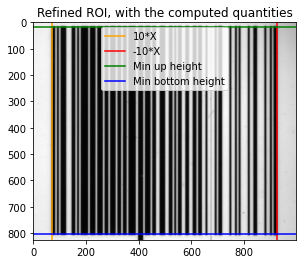

In [25]:
%%time
refine_roi(f'../images/{images_paths[0]}')

Threshold1: 118.0
Threshold2: 102.0
Wall time: 135 ms


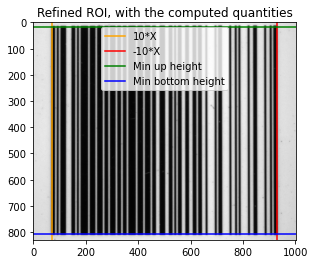

In [27]:
%%time
refine_roi(f'../images/{images_paths[1]}')

Threshold1: 114.0
Threshold2: 84.0
Wall time: 91.6 ms


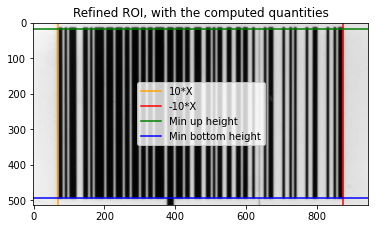

In [28]:
%%time
refine_roi(f'../images/{images_paths[2]}')

In [31]:
for i in [i for i in range(53) if i!=21]:
    print(i)
    refine_roi(f'../images/{images_paths[i]}', visualize=False)
    print()

0
Threshold1: 115.0
Threshold2: 103.0

1
Threshold1: 118.0
Threshold2: 102.0

2
Threshold1: 114.0
Threshold2: 84.0

3
Threshold1: 109.0
Threshold2: 84.0

4
Threshold1: 116.0
Threshold2: 84.0

5
Threshold1: 111.0
Threshold2: 84.0

6
Threshold1: 114.0
Threshold2: 85.0

7
Threshold1: 114.0
Threshold2: 86.0

8
Threshold1: 113.0
Threshold2: 84.0

9
Threshold1: 120.0
Threshold2: 115.0

10
Threshold1: 122.0
Threshold2: 114.0

11
Threshold1: 121.0
Threshold2: 115.0

12
Threshold1: 124.0
Threshold2: 115.0

13
Threshold1: 107.0
Threshold2: 88.0

14
Threshold1: 115.0
Threshold2: 110.0

15
Threshold1: 117.0
Threshold2: 123.0

16
Threshold1: 117.0
Threshold2: 113.0

17
Threshold1: 104.0
Threshold2: 85.0

18
Threshold1: 112.0
Threshold2: 111.0

19
Threshold1: 112.0
Threshold2: 114.0

20
Threshold1: 113.0
Threshold2: 109.0

22
Threshold1: 115.0
Threshold2: 130.0

23
Threshold1: 114.0
Threshold2: 123.0

24
Threshold1: 112.0
Threshold2: 112.0

25
Threshold1: 106.0
Threshold2: 105.0

26
Threshold1: 98.0

DIfferent thresholds... Maybe it is better to leave the situation as it is: two different thresholds.